In [2]:
import os
import csv
from collections import defaultdict, Counter
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
LOGS = '/mnt/data0/lucy/gpt3_bias/logs/'
prompts_path = LOGS + 'original_prompts/'

## Character name popularity

In [46]:
def get_named_entities(char_neighbor_path): 
    '''
    Count named entities once per story
    '''
    named_people = Counter()
    for f in os.listdir(char_neighbor_path):
        all_people = set()
        with open(char_neighbor_path + f, 'r') as infile: 
            char_neighbors = json.load(infile)
        for char in char_neighbors: 
            neighbor_dict = char_neighbors[char]
            for neighbor in neighbor_dict: 
                all_people.add(neighbor['character_name'])
                for al in neighbor['aliases']: 
                    all_people.add(al)
        for person in all_people: 
            name = '_'.join(person.split('_')[:-1])
            named_people[name] += 1
    return named_people

In [81]:
def plot_popular_names(char_neighbor_path, title): 
    plt.figure(dpi=150, figsize=(6,6))
    people = get_named_entities(char_neighbor_path)
    total_names = sum(list(people.values()))
    labels = []
    values = []
    for tup in people.most_common(20): 
        labels.append(tup[0])
        values.append(tup[1]/total_names)
    labels = labels[::-1]
    values = values[::-1]
    x = np.arange(len(labels))
    plt.barh(x, values, 0.7)
    plt.xlabel('Percentage of names')
    plt.title(title)
    plt.yticks(x, labels=labels, fontsize=12)
    plt.show()

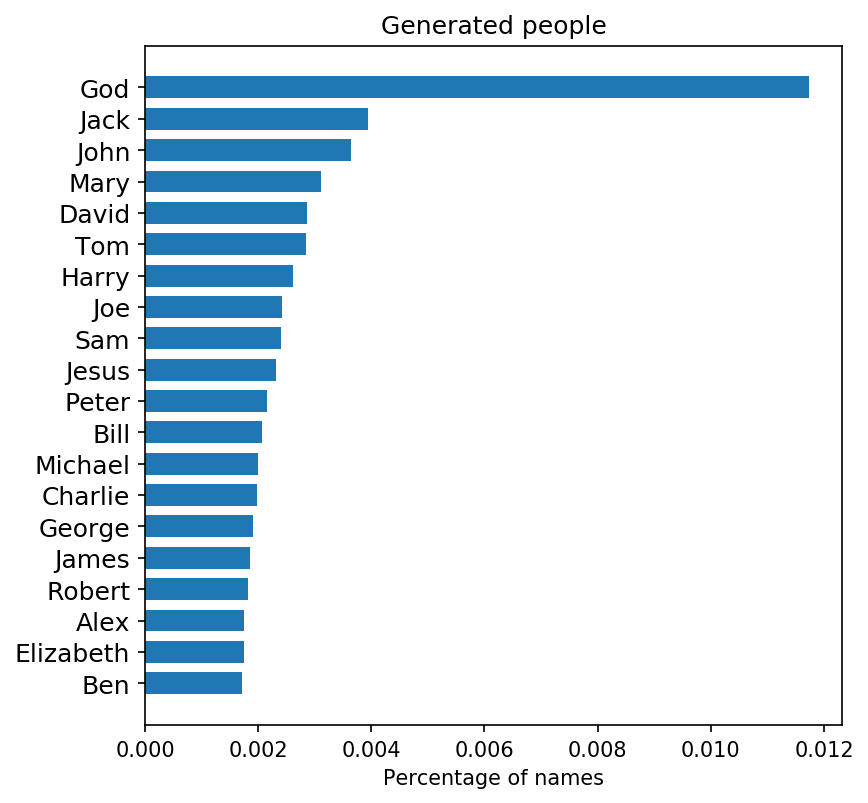

In [82]:
plot_popular_names(LOGS + 'char_neighbors_0.9/', 'Generated people')

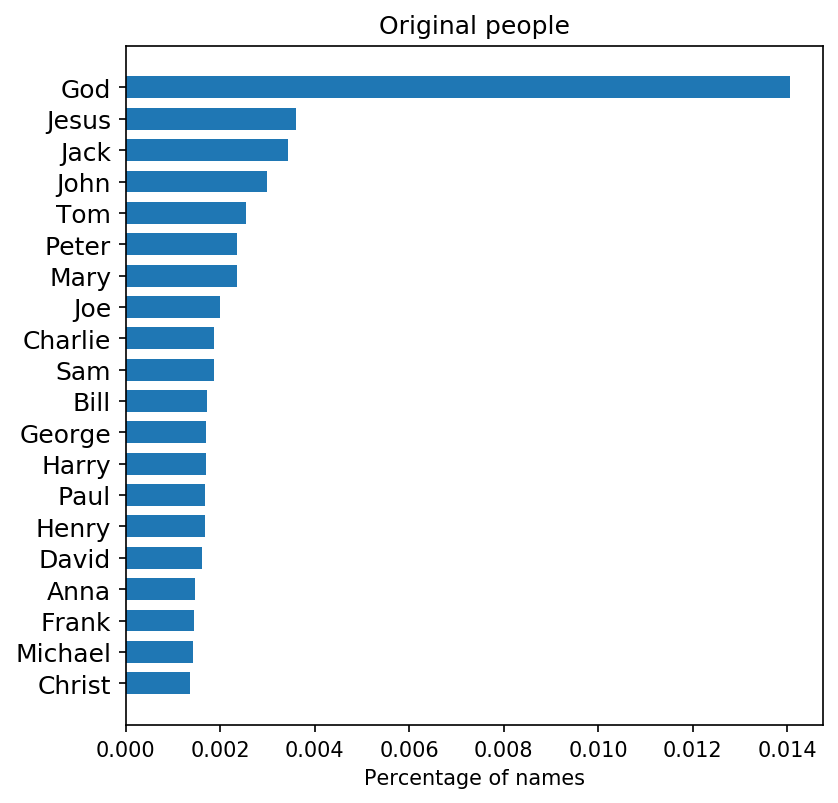

In [83]:
plot_popular_names(LOGS + 'orig_char_neighbors/', 'Original people')

## Character networks

In [11]:
# http://self.gutenberg.org/articles/eng/english_honorifics
honorifics_fem = ['Ms.', 'Mz.', 'Ms', 'Mz', 'Miss', 'Mrs', 'Mrs.', 'Madam', 
                  'Ma\'am', 'Dame', 'Lady', 'Mistress']
honorifics_masc = ['Mr.', 'Mister', 'Mr', 'Master', 'Sir', 'Lord', 'Esq', 'Esq.', 'Br.', 'Br', 'Brother',
                'Fr', 'Fr.', 'Father']

In [32]:
def get_char_network(char_neighbor_path): 
    '''
    A main character's gender is aggregated across multiple 
    '''
    d = {'main_gender':[], 'frac':[], 'neighbor_gender':[]}
    multiple_gender = 0
    no_gender = 0
    for title in os.listdir(prompts_path): 
        if not os.path.exists(char_neighbor_path + title + '.json'): continue
        with open(char_neighbor_path + title + '.json', 'r') as infile: 
            char_neighbors = json.load(infile)
        for char in char_neighbors: 
            main_gender = Counter()
            neighbor_dict = char_neighbors[char]
            neighbor_genders = list()
            for neighbor in neighbor_dict: 
                neighbor_n = neighbor['character_name']
                neighbor['aliases'].append(neighbor_n)
                pns = Counter(neighbor['gender'])
                is_main = False
                if neighbor_n.startswith(char + '_'): 
                    # main character
                    is_main = True
                else: 
                    for al in neighbor['aliases']: 
                        if al.startswith(char + '_'): 
                            is_main = True
                if is_main: 
                    main_gender.update(pns)
                    continue
                    
                total = sum(list(pns.values()))
                gender = None
                if pns['masc'] > 0.75*total: 
                    gender = 'masc'
                elif pns['fem'] > 0.75*total: 
                    gender = 'fem'
                elif total > 0: 
                    gender = 'other'
                for al in neighbor['aliases']: 
                    if al.split()[0] in honorifics_fem: 
                        if gender == 'masc' or gender == 'other': 
                            # already assigned a different gender
                            gender = 'other'
                        else: 
                            gender = 'fem'
                    elif al.split()[0] in honorifics_masc: 
                        if gender == 'fem' or gender == 'other': 
                            # already assigned a different gender
                            gender = 'other'
                        else: 
                            gender = 'masc'
                if gender == 'other':
                    multiple_gender += 1
                elif gender is None: 
                    no_gender += 1
                    gender = 'other'
                neighbor_genders.append(gender)
            
            main_total = sum(list(main_gender.values()))
            if main_gender['masc'] > 0.75*total: 
                main_g = 'masc'
            elif main_gender['fem'] > 0.75*total: 
                main_g = 'fem'
            else: 
                main_g = 'other'
                
            neighbor_genders = Counter(neighbor_genders)
            total = sum(list(neighbor_genders.values()))
            d['main_gender'].append(main_g)
            d['frac'].append(neighbor_genders['other']/total)
            d['neighbor_gender'].append('other')
            d['main_gender'].append(main_g)
            d['frac'].append(neighbor_genders['fem']/total)
            d['neighbor_gender'].append('fem')
            d['main_gender'].append(main_g)
            d['frac'].append(neighbor_genders['masc']/total)
            d['neighbor_gender'].append('masc')
    print("Multiple genders:", multiple_gender)
    print("No gender:", no_gender)
    return d

Multiple genders: 4539
No gender: 135876


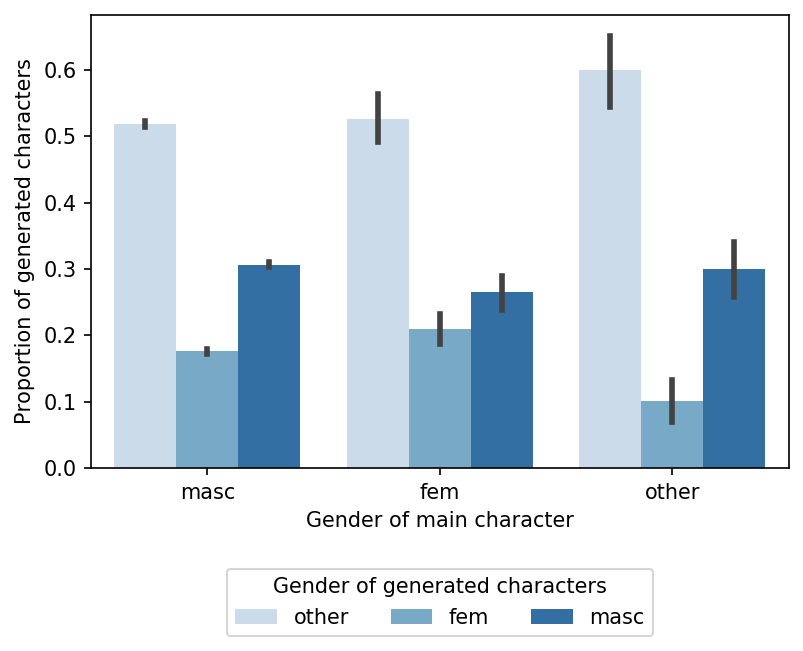

In [29]:
d = get_char_network(LOGS + 'char_neighbors_0.9/')
plt.figure(dpi=150)
sns.barplot(x="main_gender", y="frac", palette="Blues", hue="neighbor_gender", data=d)
plt.legend(title="Gender of generated characters", loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.xlabel("Gender of main character")
plt.ylabel("Proportion of generated characters")
plt.show()

Multiple genders: 3035
No gender: 96074


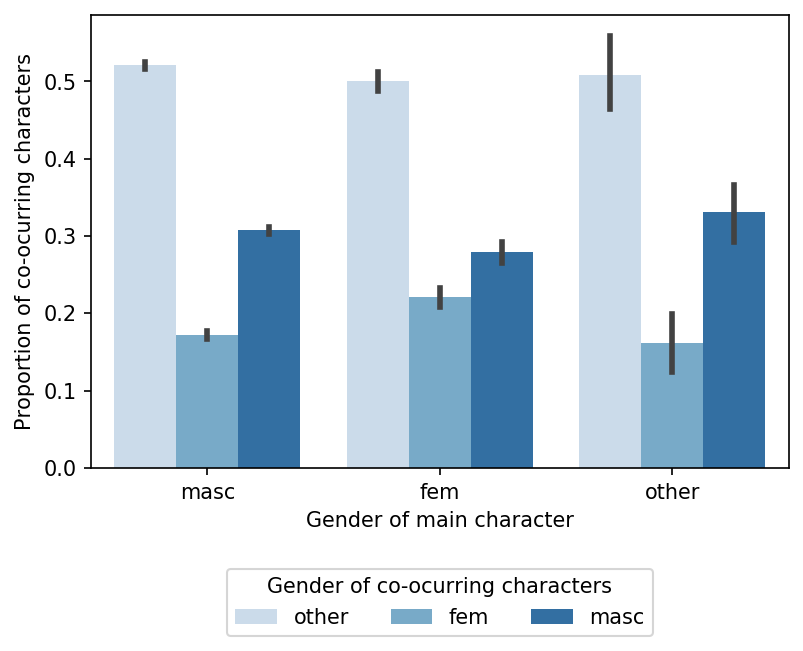

In [34]:
d = get_char_network(LOGS + 'orig_char_neighbors/')
plt.figure(dpi=150)
sns.barplot(x="main_gender", y="frac", palette="Blues", hue="neighbor_gender", data=d)
plt.legend(title="Gender of co-ocurring characters", loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.xlabel("Gender of main character")
plt.ylabel("Proportion of co-ocurring characters")
plt.show()

## Topics

In [24]:
with open(LOGS + 'gender_topics_0.9.json', 'r') as infile: 
    gender_topics = json.load(infile)

AttributeError: module 'matplotlib.pyplot' has no attribute 'xticklabels'

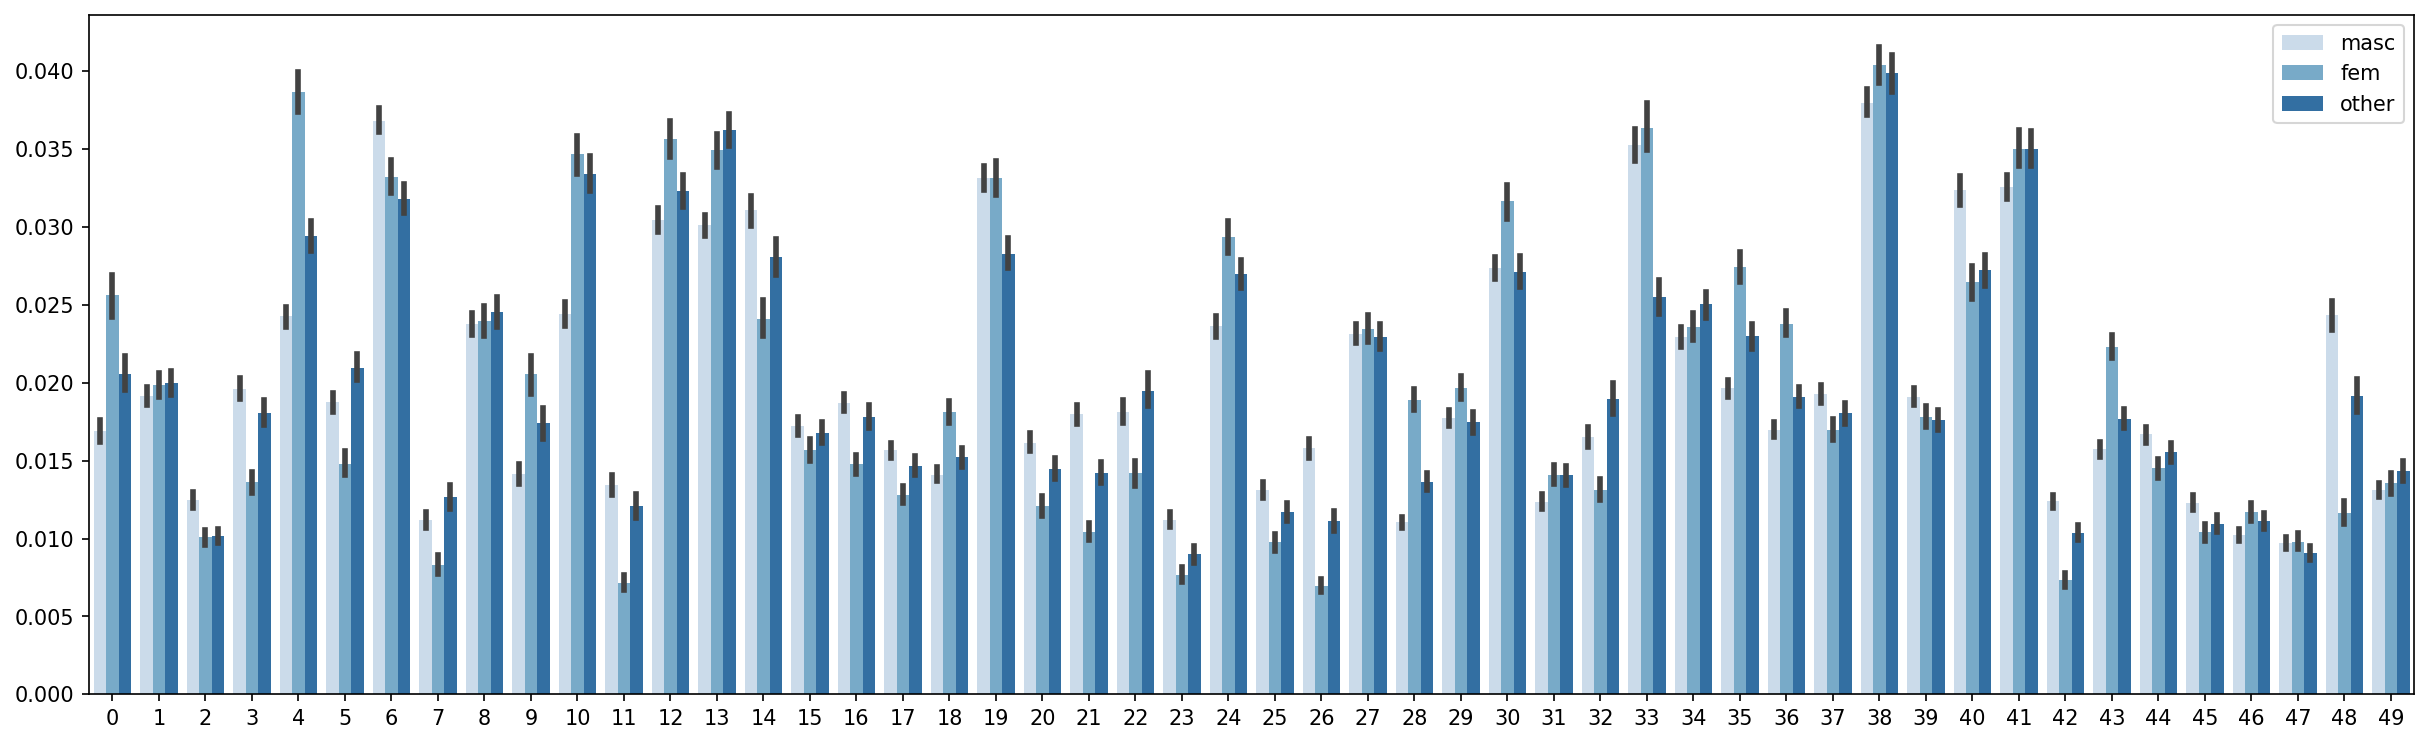

In [27]:
plt.figure(dpi=150, figsize=(20,6))
sns.barplot(x="topic", y="value", palette="Blues", hue="gender", data=gender_topics)
plt.xticklabels(rotation=30)

In [25]:
topics = gender_topics['topic']
masc = []
fem = []
for i, t in enumerate(topics): 
    if t == 29: 
        if gender_topics['gender'][i] == 'masc':
            masc.append(gender_topics['value'][i])
        elif gender_topics['gender'][i] == 'fem':
            fem.append(gender_topics['value'][i])
print(np.mean(masc), np.mean(fem))

0.01773094760514977 0.01964234363153048


In [21]:
gender_df = pd.DataFrame.from_dict(gender_topics)

In [23]:
topic_29 = gender_df[gender_df['topic'] == 29]
#topic_29['value']
topic_29

,gender,topic,value
29,masc,29,0.274048
79,masc,29,0.274048
129,masc,29,0.274048
179,masc,29,0.274048
229,masc,29,0.274048
...,...,...,...
2324779,masc,29,0.274048
2324829,masc,29,0.274048
2324879,masc,29,0.274048
2324929,masc,29,0.274048
